In [5]:
import datetime as dt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load data

In [6]:
data = pd.read_excel('data.xlsx')

In [7]:
data.head(5) # 5 dòng đầu tiên

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Xử lý

### Loại bỏ giá trị none

In [9]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


# Tính toán RFM

#### Recency (Recently): Thời gian giao dịch gần nhất | [1-3], 1 là cao nhất

In [10]:
data['InvoiceDate'].describe()

count                           406829
mean     2011-07-10 16:30:57.879207424
min                2010-12-01 08:26:00
25%                2011-04-06 15:02:00
50%                2011-07-31 11:48:00
75%                2011-10-20 13:06:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [11]:
# chuyển về dạng date
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d%m%y')
# data['InvoiceDate'].describe()

In [12]:
# Vì là dữ liệu quá khứ, nên sẽ chọn ngày hiện tại là ngày mới nhất trong hoá đơn + 1 ngày
current_date = max(data['InvoiceDate']) + dt.timedelta(days=1)
current_date

Timestamp('2011-12-10 12:50:00')

#### Monetary: Tổng số tiền đã chi tiêu | [1-3], 1 là cao nhất

In [13]:
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data[data['TotalPrice'] <= 0] 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,-1.25


#### Group by Customer ID để tính RFM

In [14]:
customer = data.groupby('CustomerID').agg({
  'InvoiceDate': lambda x: (current_date - x.max()).days, # R    
  'InvoiceNo': 'count',                                   # F
  'TotalPrice': 'sum'                                     # M
})
customer

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


In [15]:
customer.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'Monetary'}, inplace=True)

#### Xoá các khách hàng có doanh thu < 0

In [16]:
customer = customer[customer["Monetary"] > 0]
customer

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
12352.0,36,95,1545.41
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


## Kiểm tra Skewness - Độ lệch

C:\Users\Nomocp\AppData\Local\Temp\ipykernel_6236\5520748.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['Recency'], ax = ax[0])
C:\Users\Nomocp\AppData\Local\Temp\ipykernel_6236\5520748.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['Frequency'], ax = ax[1])
C:\Users

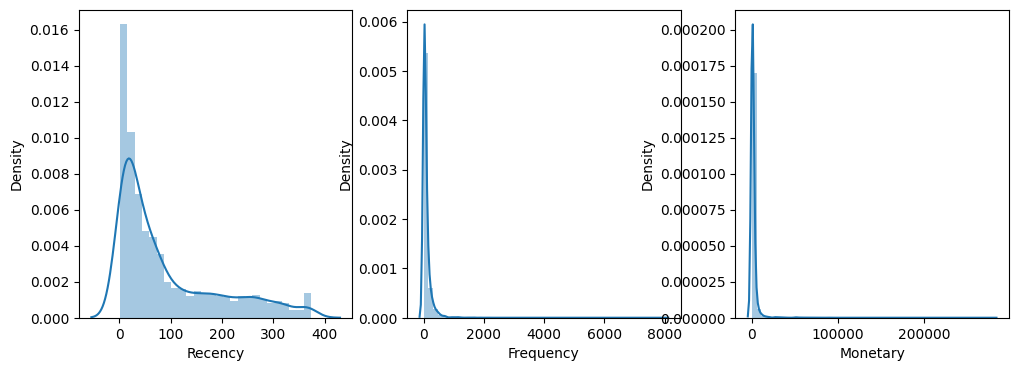

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))
sns.distplot(customer['Recency'], ax = ax[0])
sns.distplot(customer['Frequency'], ax = ax[1])
sns.distplot(customer['Monetary'], ax = ax[2])
plt.show()

### Transform, Giảm Skewness - độ lệch

In [18]:
from scipy import stats
def analyze_skewness(dataFrame, x):    # Hàm đánh giá với các loại transform
  fig, ax = plt.subplots(2, 3, figsize=(10, 6))
  sns.histplot(dataFrame[x], ax=ax[0, 0], kde=True, stat="proportion")
  sns.histplot(np.log(dataFrame[x]), ax=ax[0, 1], kde=True, stat="proportion")
  sns.histplot(np.sqrt(dataFrame[x]), ax=ax[0, 2], kde=True, stat="proportion")
  sns.histplot(np.cbrt(dataFrame[x]), ax=ax[1, 0], kde=True, stat="proportion")
  sns.histplot(stats.boxcox(dataFrame[x])[0], ax=ax[1, 1], kde=True, stat="proportion")
  plt.tight_layout()
  plt.show()
  
  print(f'- Original: {dataFrame[x].skew().round(2)}')
  print(f'- Log Transformation: {np.log(dataFrame[x]).skew().round(2)}')
  print(f'- Square Root Transformation: {np.sqrt(dataFrame[x]).skew().round(2)}')
  print(f'- Cube Root Transformation: {np.cbrt(dataFrame[x]).skew().round(2)}')
  print(f'- Box-cox Transformation: {pd.Series(stats.boxcox(dataFrame[x])[0]).skew().round(2)}')

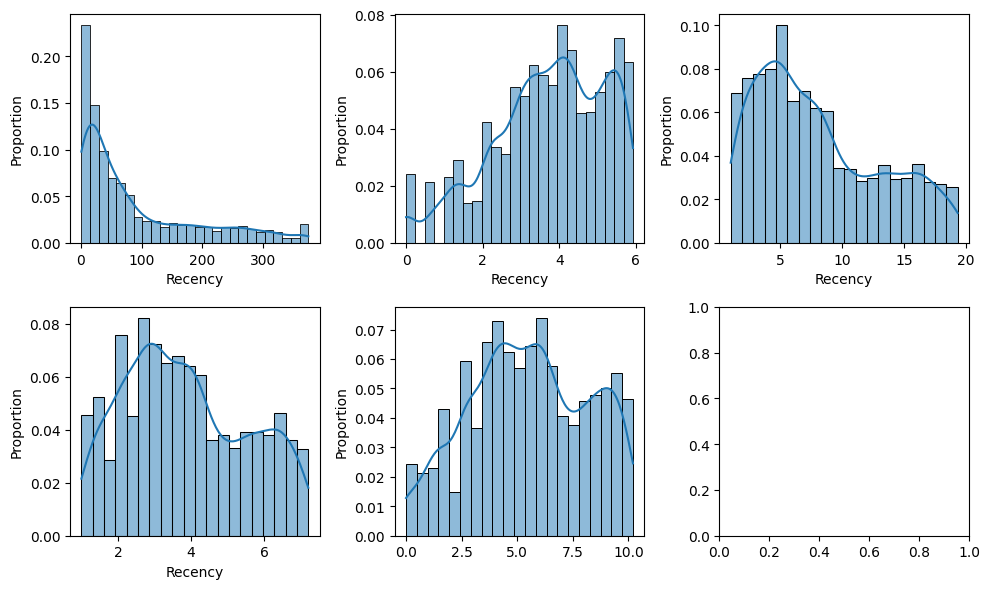

- Original: 1.27
- Log Transformation: -0.53
- Square Root Transformation: 0.6
- Cube Root Transformation: 0.29
- Box-cox Transformation: -0.07


In [19]:
analyze_skewness(customer, 'Recency')

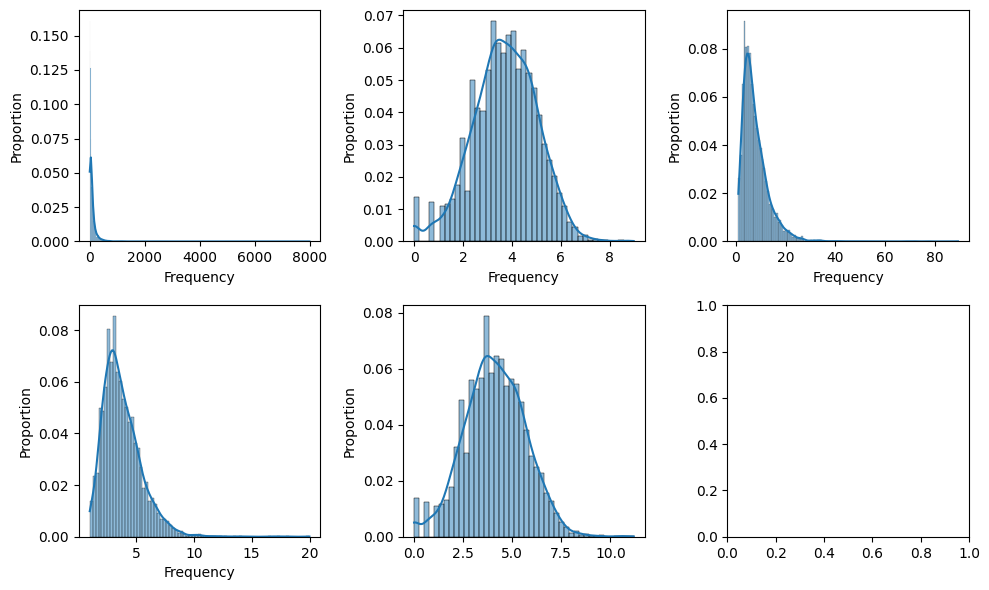

- Original: 18.08
- Log Transformation: -0.2
- Square Root Transformation: 3.23
- Cube Root Transformation: 1.52
- Box-cox Transformation: 0.0


In [20]:
analyze_skewness(customer, 'Frequency')

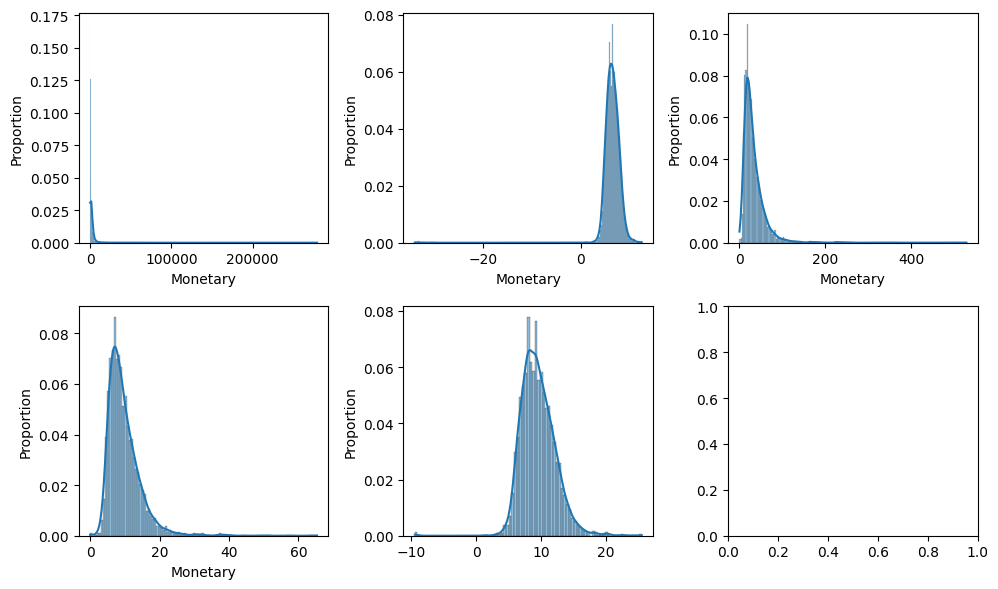

- Original: 21.6
- Log Transformation: -11.31
- Square Root Transformation: 5.82
- Cube Root Transformation: 2.85
- Box-cox Transformation: 0.39


In [21]:
analyze_skewness(customer, 'Monetary')

In [22]:
# => Chọn Box-Cox Transformation

#### Transform data

In [23]:
customer_temp = pd.DataFrame()
customer_temp['Recency'] = stats.boxcox(customer['Recency'])[0]
customer_temp['Frequency'] = stats.boxcox(customer['Frequency'])[0]
customer_temp['Monetary'] = pd.Series(np.cbrt(customer['Monetary'])).values
# customer_temp['Monetary'] = stats.boxcox(customer['Monetary'])[0]
customer_temp

,Recency,Frequency,Monetary
0,0.735526,5.898432,16.273929
1,6.365919,3.727781,12.158183
2,3.818750,4.755491,12.068017
3,9.702147,3.031275,6.941001
4,4.930823,5.080015,11.561510
...,...,...,...
4317,9.416599,2.432296,5.652483
4318,8.341851,2.038021,4.323541
4319,2.493224,2.726581,5.610440
4320,1.562786,7.781244,12.795376


#### Scale data (Chuẩn hoá) về 1 phạm vi giá trị

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customer_temp) # tính toán mean và standard deviation của attributes
customer_temp_scaled = scaler.transform(customer_temp)  # Tiến hành scale

In [25]:
pd.DataFrame(customer_temp_scaled) # Chuyển thành dạng data frame

,0,1,2
0,-1.795558,1.147584,1.354593
1,0.324090,-0.243465,0.495975
2,-0.634831,0.415136,0.477165
3,1.580065,-0.689818,-0.592422
4,-0.216174,0.623106,0.371499
...,...,...,...
4317,1.472566,-1.073670,-0.861230
4318,1.067960,-1.326338,-1.138471
4319,-1.133845,-0.885079,-0.870001
4320,-1.484123,2.354173,0.628905


## K Means


#### Elbow distortion

c:\Users\Nomocp\.virtualenvs\customer_segment-ZIwhvYs6\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Nomocp\.virtualenvs\customer_segment-ZIwhvYs6\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Nomocp\.virtualenvs\customer_segment-ZIwhvYs6\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Nomocp\.virtualenvs\customer_segment-ZIwhvYs6\Lib\site-packages\sklearn\clus

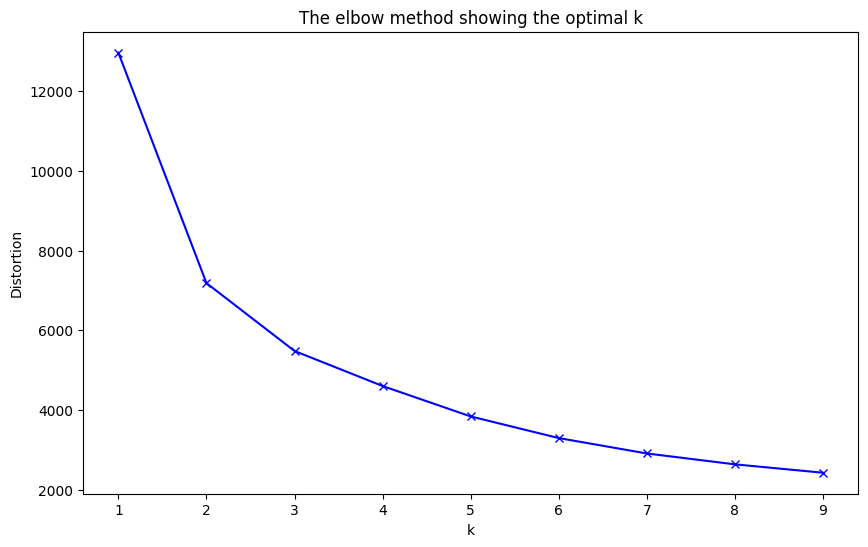

In [27]:
distortions = []
K = range(1, 10)
for i in K:
  kmeanModel = KMeans(n_clusters=i)
  kmeanModel.fit(customer_temp_scaled)
  distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The elbow method showing the optimal k')
plt.show()

In [28]:
cluster = 4
model = KMeans(n_clusters=cluster, random_state=99)
model.fit(customer_temp_scaled)

c:\Users\Nomocp\.virtualenvs\customer_segment-ZIwhvYs6\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


#### Gán cụm

In [30]:
customer_temp['Group'] = model.labels_
customer_temp

,Recency,Frequency,Monetary,Group
0,0.735526,5.898432,16.273929,3
1,6.365919,3.727781,12.158183,2
2,3.818750,4.755491,12.068017,2
3,9.702147,3.031275,6.941001,1
4,4.930823,5.080015,11.561510,2
...,...,...,...,...
4317,9.416599,2.432296,5.652483,1
4318,8.341851,2.038021,4.323541,1
4319,2.493224,2.726581,5.610440,0
4320,1.562786,7.781244,12.795376,3


#### Đặc điểm từng cụm

In [34]:
customer_temp.groupby('Group').agg({
  'Recency' : 'mean',
  'Frequency' : 'mean',
  'Monetary' : 'mean',  
}).round(0)

,Recency,Frequency,Monetary
Group,,,
0,5.0,3.0,7.0
1,9.0,3.0,7.0
2,4.0,5.0,11.0
3,2.0,7.0,20.0


#### Vẽ biểu đồ phân cụm dữ liệu

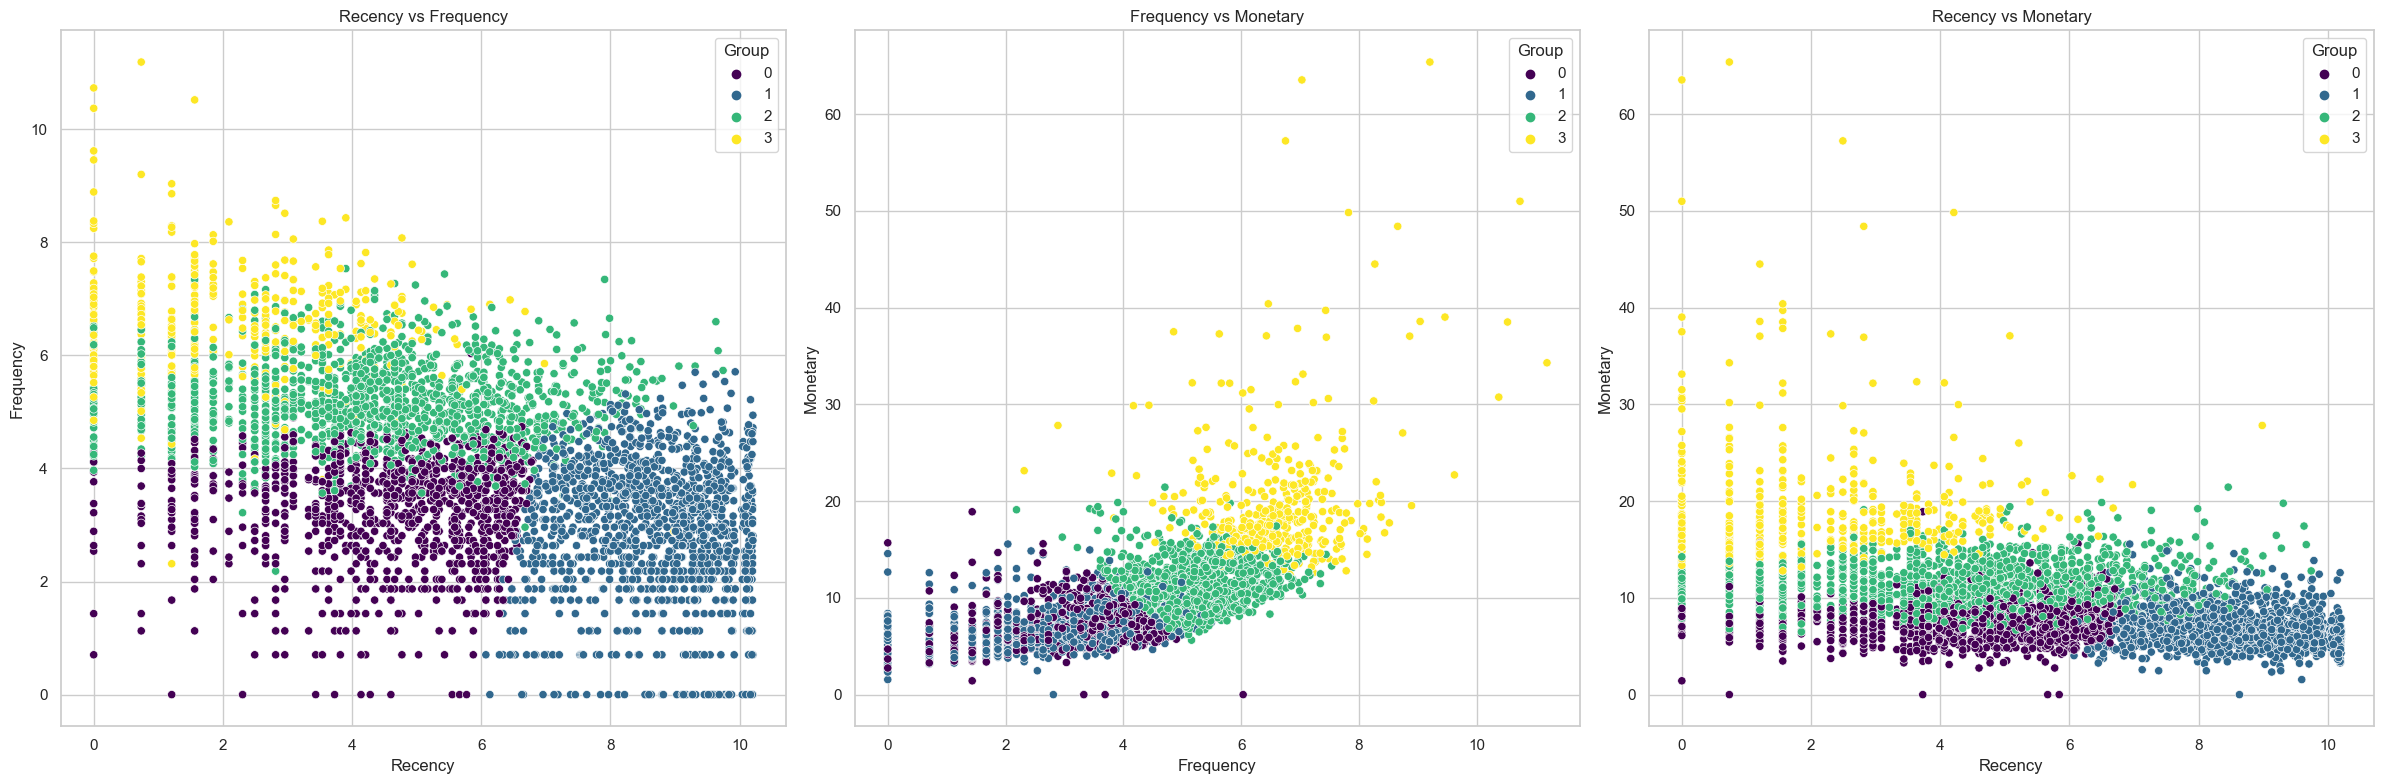

In [53]:
# Tạo biểu đồ sử dụng Seaborn
sns.set(style="whitegrid")

# Biểu đồ Recency và Frequency
plt.figure(figsize=(24, 8))
plt.subplot(131)    # hàng 1 - cột 3 - vị trí 1
sns.scatterplot(x='Recency', y='Frequency', data=customer_temp, hue='Group', palette='viridis')
plt.title('Recency vs Frequency')

# Biểu đồ Frequency và Monetary
plt.subplot(132)
sns.scatterplot(x='Frequency', y='Monetary', data=customer_temp, hue='Group', palette='viridis')
plt.title('Frequency vs Monetary')

# Biểu đồ Recency và Monetary
plt.subplot(133)
sns.scatterplot(x='Recency', y='Monetary', data=customer_temp, hue='Group', palette='viridis')
plt.title('Recency vs Monetary')
plt.tight_layout()
plt.show()